# Explorative Data Analysis - CO2 Emissions

## Objective
In this notebook, the CO₂ emissions based on the fuel consumption of vehicles in Canada in 2020 are analyzed. The main objective is to identify features of vehicles that affect the amount of emissions the most. Other objectives are 

## Data
The dataset used in this notebook is publisehd in: https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64#wb-auto-6


## Steps
The steps taken in this notebook:
- [Step 1](#step_1)
    : Importing Libraries and Dataset
- [Step 2](#step_2)
    : Dataset Informations + Data Quality
- [Step 3](#step_3)
    : Car Manufacturers
- [Step 4](#step_4)
    : Vehicle Classes

## <a id="step_1">Step 1: Importing Libraries and Dataset</a>

In [131]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [132]:
# nrows is set to 967, since the csv file includes a describtion of the columns below the actual table, making it necessary to specify nrows to only include the table 
df = pd.read_csv(os.path.join('Datasets','MY2020 Fuel Consumption Ratings.csv'), header=[0,1], nrows=967)

## <a id="step_2">Step 2: Dataset Informations  + Data Quality</a>

The dataset contains model-specific fuel consumption and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada 

To understand the dataset, the csv file contains following explainations:
#### Model
- 4WD/4X4 = Four-wheel drive
- AWD = All-wheel drive
- FFV = Flexible-fuel vehicle
- SWB = Short wheelbase
- LWB = Long wheelbase
- EWB = Extended wheelbase
#### Transmission	
- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual
- 3 – 10 = Number of gears
#### Fuel type
- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas
#### Fuel consumption
City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg)
#### CO2 emissions
the tailpipe emissions of carbon dioxide (in grams per kilometre) for combined city and highway driving
#### CO2 rating
the tailpipe emissions of carbon dioxide rated on a scale from 1 (worst) to 10 (best)
#### Smog rating
the tailpipe emissions of smog-forming pollutants rated on a scale from 1 (worst) to 10 (best)


In [133]:
df.head()

,Model,Make,Model,Vehicle Class,Engine Size,Cylinders,Transmission,Fuel,Fuel Consumption,Unnamed: 9_level_0,...,Unnamed: 211_level_0,Unnamed: 212_level_0,Unnamed: 213_level_0,Unnamed: 214_level_0,Unnamed: 215_level_0,Unnamed: 216_level_0,Unnamed: 217_level_0,Unnamed: 218_level_0,Unnamed: 219_level_0,Unnamed: 220_level_0
,Year,Unnamed: 1_level_1,Unnamed: 2_level_1,Unnamed: 3_level_1,(L),Unnamed: 5_level_1,Unnamed: 6_level_1,Type,City (L/100 km),Hwy (L/100 km),...,Unnamed: 211_level_1,Unnamed: 212_level_1,Unnamed: 213_level_1,Unnamed: 214_level_1,Unnamed: 215_level_1,Unnamed: 216_level_1,Unnamed: 217_level_1,Unnamed: 218_level_1,Unnamed: 219_level_1,Unnamed: 220_level_1
0,2020,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS9,Z,12.3,9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6,AS9,Z,12.2,9.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,Acura,MDX Hybrid AWD,SUV: Small,3.0,6,AM7,Z,9.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,Acura,RDX AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains a lot of completely empty columns, so at first, all columns that contain not a single value are dropped
Further, the second row filled the headers with unnecessary information, which will be renamed

In [134]:
df = df.dropna(axis=1, how='all')

cols_level0 = df.columns.get_level_values(level=0).str.replace('Unnamed.*','Fuel Consumption')
cols_level1 = df.columns.get_level_values(level=1).str.replace('Unnamed.*','')
df.columns = [cols_level0,cols_level1]
df.head()

Model   Make              Model Vehicle Class Engine Size Cylinders  \
   Year                                                 (L)             
0  2020  Acura                ILX       Compact         2.4         4   
1  2020  Acura         MDX SH-AWD    SUV: Small         3.5         6   
2  2020  Acura  MDX SH-AWD A-SPEC    SUV: Small         3.5         6   
3  2020  Acura     MDX Hybrid AWD    SUV: Small         3.0         6   
4  2020  Acura            RDX AWD    SUV: Small         2.0         4   

  Transmission Fuel Fuel Consumption                                 \
               Type  City (L/100 km) Hwy (L/100 km) Comb (L/100 km)   
0          AM8    Z              9.9            7.0             8.6   
1          AS9    Z             12.3            9.2            10.9   
2          AS9    Z             12.2            9.5            11.0   
3          AM7    Z              9.1            9.0             9.0   
4         AS10    Z             11.0            8.6             9.9   

             CO2 Emissions    CO2   Smog  
  Comb (mpg)        (g/km) Rating Rating  
0         33           199      6      3  
1         26           254      4      3  
2         26           258      4      3  
3         31           210      5      3  
4         29           232      5      6

In [135]:
# Flatten multiindex columns to simplify the analysis and avoid PerformanceWarnings
df.columns = [' '.join(col).strip() for col in df.columns.values]

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Model Year                        967 non-null    int64  
 1   Make                              967 non-null    object 
 2   Model                             967 non-null    object 
 3   Vehicle Class                     967 non-null    object 
 4   Engine Size (L)                   967 non-null    float64
 5   Cylinders                         967 non-null    int64  
 6   Transmission                      967 non-null    object 
 7   Fuel Type                         967 non-null    object 
 8   Fuel Consumption City (L/100 km)  967 non-null    float64
 9   Fuel Consumption Hwy (L/100 km)   967 non-null    float64
 10  Fuel Consumption Comb (L/100 km)  967 non-null    float64
 11  Fuel Consumption Comb (mpg)       967 non-null    int64  
 12  CO2 Emis

As can be seen in the info, the dataset not a single NaN value in the remaining columns. So there is no need to apply any imputation methods to get rid of the missing values.

Further, the dataset contains 5 categorical columns that need to be encoded when training most machine learning algorithms. The remaining columns are containing integers and floats. The variables that are suitable for use as target variables when training an algorithm, such as CO₂ emissions or smog, are available as integers.

In [137]:
# df.describe()

## <a id="step_3">Step 3: Car Manufacturers</a>

Which manufacturers are present in the dataset?

In [138]:
df['Make'].unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'Bentley', 'BMW',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge',
       'FIAT', 'Ford', 'Genesis', 'GMC', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Maserati', 'Mazda', 'Mercedes-Benz', 'MINI',
       'Mitsubishi', 'Nissan', 'Porsche', 'Ram', 'Rolls-Royce', 'Subaru',
       'Toyota', 'Volkswagen', 'Volvo'], dtype=object)

Are there different amount of Models per manufacturer in the dataset? If so, which manufacturers are represented more/less often represented due to the amount of different vehicles included? 

<AxesSubplot:xlabel='index', ylabel='Make'>

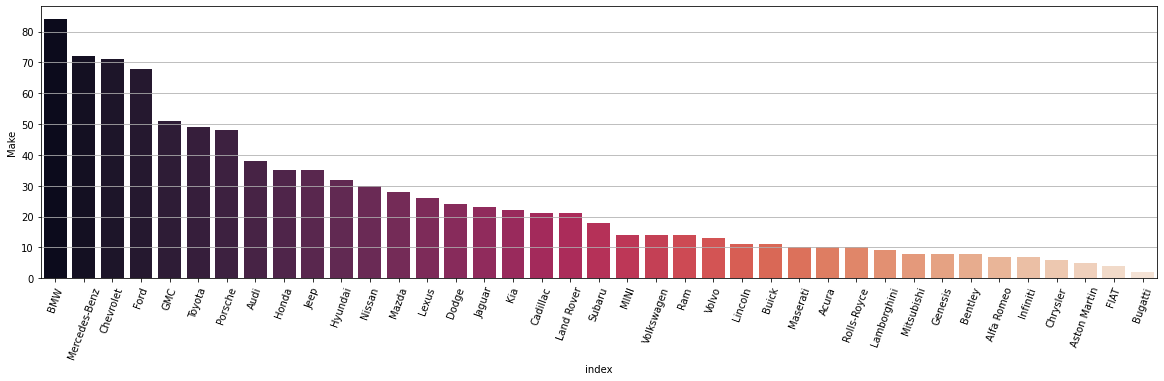

In [168]:
manufacturers_counts = df['Make'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_counts, x=manufacturers_counts['index'], y=manufacturers_counts[manufacturers_counts.columns[1]], palette="rocket")

#### Average CO2 emissions per manufacturer 

<AxesSubplot:xlabel='Make', ylabel='CO2 Emissions (g/km)'>

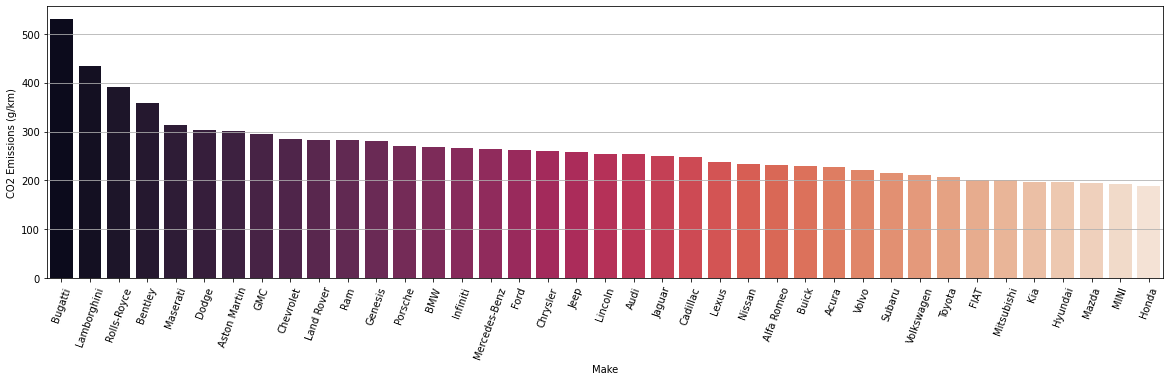

In [165]:
manufacturers_CO2 = df.groupby('Make').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_CO2, x=manufacturers_CO2['Make'], y=manufacturers_CO2['CO2 Emissions (g/km)'], palette="rocket")


On average, the vehicles by the car manufacturers 'Bugatti', 'Lamborghini' and 'Rolls-Royce' emit the most CO2 (g/km). 

 ## <a id="step_4">Step 4: Vehicle Classes</a>